# Handwritten Text Recognition - OCR - CNN

In [50]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import random
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [51]:
# Data Acquisition
DATA = "../data/raw"
LETS = list("SINO")
NUM_LETS = len(LETS)
IMG_SIZE = 100

In [52]:
# Loading all letter images, resizing and labeling them
def load_letters(path, letters_list):
    letters = []
    # Looping through each letter folder
    for let in letters_list:
        images = os.listdir(os.path.join(path, let))
        # Looping through each image within a specific letter folder
        for pic in images:
            # Reading letter image, turning it to gray scale and resizing it
            img = cv2.imread(os.path.join(path, let, pic))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
            
            # Saving letter image array and target into a list
            letters.append([resized, letters_list.index(let)])
    
    return letters
        
letters = load_letters(DATA, LETS)
print(len(letters))

120


In [53]:
# Checking how many images were read per letter
def check_loaded_data(loaded_letters_list, individual_letters_list):
    y = [target[1] for target in loaded_letters_list]
    res = [[letter, y.count(individual_letters_list.index(letter))] for letter in individual_letters_list]
    print(res)

check_loaded_data(letters, LETS)

[['S', 30], ['I', 30], ['N', 30], ['O', 30]]


In [54]:
# Checking loaded images
def shuffle(list_to_shuffle):
    random.shuffle(list_to_shuffle)
    return list_to_shuffle

shuffled = shuffle(letters)
print(len(shuffled))

120


In [55]:
# Splitting training data with its correspondent label
def split_xy(training_data):
    X, y = [], []
    for features, label in training_data:
        X.append(features)
        y.append(label)

    return X, y

X, y = split_xy(shuffled)

print(len(X))
print(y[0])
print(X[0])

120
2
[[159 159 159 ... 165 166 167]
 [159 159 159 ... 165 166 167]
 [159 159 159 ... 165 166 167]
 ...
 [159 159 159 ... 166 166 166]
 [159 159 159 ... 163 164 166]
 [159 159 159 ... 164 165 166]]


In [56]:
# Converting y list into a categorical array, 0 and 1
y = tf.keras.utils.to_categorical(y, NUM_LETS)
print(y)
print(y.shape)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0.

In [57]:
# Turning lists into arrays
#print(len(X), len(y))
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # 1 grayscale, 3 colored images
#y = np.array(y)
print(X.shape, y.shape)

(120, 100, 100, 1) (120, 4)


In [58]:
# Normalizing the training data
X = tf.keras.utils.normalize(X, axis=1)
print(X.shape)

(120, 100, 100, 1)


In [59]:
# Model's name
NAME = f"OCR-CNN-{int(time.time())}"
print(NAME)

# Model instantiation and layers definition
model = Sequential() # instatiating the NN

# Adding first 2D convolution layer
model.add(Conv2D(64, (3,3), input_shape=X.shape[1:], activation="relu")) # X.shape[1:] → (100, 100, 1)
model.add(MaxPooling2D(pool_size=(2,2)))

# Adding second 2D convolution layer
model.add(Conv2D(64, (3,3), activation="relu"))# don't have to specify input shape in additional layers.
model.add(MaxPooling2D(pool_size=(2,2)))

# Adding third 2D convolution layer
model.add(Conv2D(64, (3,3), activation="relu"))# don't have to specify input shape in additional layers.
model.add(MaxPooling2D(pool_size=(2,2)))
          
# Adding flattened dense layer
model.add(Flatten())
          
# Adding output layer, 4 unit, activation softmax
model.add(Dense(NUM_LETS))
model.add(Activation("softmax"))

# Setting up tensorboard logs
tb = TensorBoard(log_dir=f"../data/logs/{NAME}")
          
# Model parameters
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

OCR-CNN-1585988495


In [60]:
# Model fitting
model.fit(X, y, batch_size=16, epochs=10, validation_split=0.2, callbacks=[tb])

Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 2s 17ms/sample - loss: 1.3983 - accuracy: 0.1250 - val_loss: 1.3865 - val_accuracy: 0.2083
Epoch 2/10
96/96 [==============================] - 1s 11ms/sample - loss: 1.3859 - accuracy: 0.2604 - val_loss: 1.3856 - val_accuracy: 0.2083
Epoch 3/10
96/96 [==============================] - 1s 11ms/sample - loss: 1.3823 - accuracy: 0.2604 - val_loss: 1.3826 - val_accuracy: 0.2500
Epoch 4/10
96/96 [==============================] - 1s 11ms/sample - loss: 1.3731 - accuracy: 0.3229 - val_loss: 1.3665 - val_accuracy: 0.2500
Epoch 5/10
96/96 [==============================] - 1s 12ms/sample - loss: 1.3356 - accuracy: 0.5312 - val_loss: 1.3134 - val_accuracy: 0.4583
Epoch 6/10
96/96 [==============================] - 1s 11ms/sample - loss: 1.2057 - accuracy: 0.7812 - val_loss: 1.1377 - val_accuracy: 0.7500
Epoch 7/10
96/96 [==============================] - 1s 12ms/sample - loss: 0.9560 - accuracy: 0.87

In [61]:
loss, acc = model.evaluate(X, y)

120/120 [==============================] - 0s 3ms/sample - loss: 0.0771 - accuracy: 0.9833


[[1.1037573e-31 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [4.1336697e-32 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [6.0884829e-33 1.0000000e+00 0.0000000e+00 0.0000000e+00]]


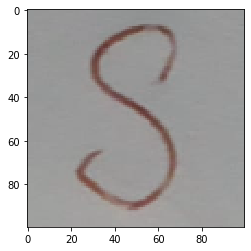

[[5.5745876e-33 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [5.6557258e-33 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [3.7484432e-34 1.0000000e+00 0.0000000e+00 0.0000000e+00]]


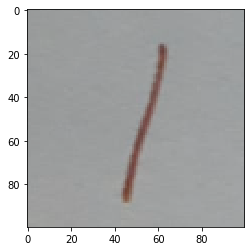

[[1.4076389e-33 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [2.4749248e-34 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [7.1593260e-35 1.0000000e+00 0.0000000e+00 0.0000000e+00]]


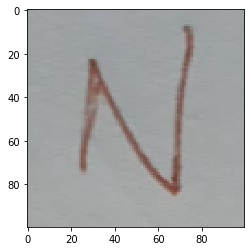

[[2.6577310e-33 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [2.9005530e-34 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0294377e-34 1.0000000e+00 0.0000000e+00 0.0000000e+00]]


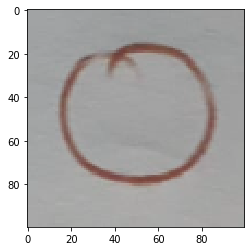

In [62]:
testpath = "../data/test"
testimages = os.listdir(testpath)
for test in testimages:
    img = cv2.imread(os.path.join(testpath, test), 1)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img, cmap="gray")
    img = np.array(img).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
    p = model.predict(img)
    print(p)
    plt.show()

In [31]:
pwd

'/home/nicolas/Reps/OCR/notebooks'